In [1]:
# 지금 이미지는 ./data/src/18-40-02-02 (SLA).jpg
# label은 ./data/src/18-40-02-02 (SLA)_re_image.png 로 존재
path = 'data'

In [2]:
src_path = path+'/src/'
label_path = path+'/label/'

In [3]:
src_image = []        # src 이미지
label_image = []    # label 이미지
for i in os.listdir(src_path):
  src_image.append(src_path + i)

for i in os.listdir(label_path):
  label_image.append(label_path + i)


------------------------------------------

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [73]:
class Augment:
  GRAY = 11
  BGR = 12
  def __init__(self, img, mask):
    """
    args:
      img : 지금은 image 경로. 추후에는 directory로 변경할 수 있음.
      mask : 지금은 label 경로. 추후에는 directory로 변경할 수 있음.
    instances:
      self.img : OpenCV로 읽어온 image
      self.mask : OpenCV로 읽어온 label
      self.rows : image의 rows
      self.cols : image의 cols
      self.channels : image의 channels
      self.temp : image와 mask가 합쳐진 numpy array
    """
    self.img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    self.mask = cv2.imread(mask, cv2.IMREAD_UNCHANGED)
    self.rows = None
    self.cols = None
    self.channels = None
    self.temp = None

  def image_mask(self, img, mask=None, color=0): # image와 mask 비교 후 조건에 맞으면 합치기
    """
    image와 mask를 비교 후 조건에 맞으면 합쳐준다. (image와 mask에 동일한 변환을 주기 위해)
    args:
      img : OpenCV로 읽어온 image
      mask : OpenCV로 읽어온 label
      color : image를 변환할 color. 0 = 원래 이미지 color, 1 = grayscale, 2 = BGR [default=0]
    returns:
      temp : image와 mask가 합쳐진 numpy array
    """
    if img.shape[:2] != mask.shape[:2]: # image 와 mask의 rows, cols의 크기는 같아야함.
      print(f"Image and mask's shape[:2] must be equal. Your image.shape[:2] = {img.shape[:2]}, and mask.shape = {mask.shape[:2]}")
      return None
    # rows, cols 을 구함
    if img.ndim == 2:
        self.rows, self.cols = img.shape
        self.channels = 1
    elif img.ndim == 3:
        self.rows, self.cols, self.channels = img.shape
    else:
        print(f"Image's ndim must be 2 or 3. Your input image's ndim is {img.ndim}")
        return None

    # image 색 변환
    if color == 0: # 그대로
      pass
    elif color == 11: # grayscale
      if self.channels == 1:
        print('Input image is already grayscale')
        pass
      elif self.channels == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      elif self.channels == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
      else:
        print(f'Maybe there is problem. self.channels = {self.channels}')
      self.channels = 1
    elif color == 12: # BGR
      if self.channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      elif self.channels == 3:
        print('Input image is already BGR')
        pass
      elif self.channels == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
      else:
        print(f'Maybe there is problem. self.channels = {self.channels}')
      self.channels = 3
    else:
      print(f'Color option must be 0, 1 or 2. Your color option = {color}')


    # image와 mask의 channel이 다를 경우 (ex: image는 3채널 rgb인데 mask는 grayscale일 경우)
    if img.shape != mask.shape:
        if img.ndim == 2:
            img = img.reshape((img.shape[0], img.shape[1], 1))
        elif mask.ndim == 2:
            mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        else:
            print(f'Maybe there is problem. img.shape = {img.shape}, mask.shape = {mask.shape}')
            return None
    else:
        if img.ndim == 2: # 둘 다 channel이 1일 경우 dimension을 추가해주어야 concate 후 분리 가능
            img = img.reshape((img.shape[0], img.shape[1], 1))
            mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

    temp = np.concatenate((img, mask), axis=-1) # img와 mask를 합친 후 한 번에 수행
    self.temp = temp
    return temp

  def translation(self, temp, x_range, y_range, control=True):
    """
    x축은 -x_range ~ x_range, y축은 -y_range ~ y_range의 범위에서 랜덤한 값으로 이미지를 이동시켜준다.
    args:
      temp : image와 mask가 합쳐진 numpy array
      x_range : x축 방향으로 이동시킬 범위
      y_range : y축 방향으로 이동시킬 범위
      control : translation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret : 변환된 image
      temp : 변환 하지 않을 때 input 을 그대로 내보내줌
    """
    if control:
      if x_range < 0 or x_range > 1 or y_range < 0 or y_range > 1:
        print(f'x_range and y_range must be 0~1')
        return None
      x_range = self.cols * x_range
      y_range = self.rows * y_range
      x = random.randint(-x_range, x_range) # 지정한 범위 내 random한 값
      y = random.randint(-y_range, y_range) # 지정한 범위 내 random한 값

      # translation matrix
      M = np.float32([[1,0,x],
                      [0,1,y]])
      ret = cv2.warpAffine(temp, M, (self.cols, self.rows)) # translation
      return ret
    else:
      return temp


  def rotation(self, temp, degree, center_range=0, control=True):
    """
    -degree ~ degree 각도의 범위 내에서 랜덤한 값으로 회전 시켜준다.
    이때, 중심은 이미지의 중심에서 각 x, y축의 -center ~ center 범위의 랜덤한 위치이다. 
    args:
      temp : image와 mask가 합쳐진 numpy array
      degree : 회전시킬 각도 범위
      center_range : 회전시킬 중심의 범위 (0~1). 0이면 image의 중심. [default=0]
      control : rotation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret : 변환된 image
      temp : 변환 하지 않을 때 input 을 그대로 내보내줌
    """
    if control:
      if center_range < 0 or center_range > 1:
        print(f'center_range must be 0~1')
        return None
      degree = np.abs(degree)
      if center_range != 0: # 회전 중심 위치
          range_x = self.cols * center_range
          range_y = self.rows * center_range
          center_x = random.randint(-range_x, range_x)
          center_y = random.randint(-range_y, range_y)
      else:
          center_x = 0
          center_y = 0

      degree_ = random.randint(-degree, degree)
      M = cv2.getRotationMatrix2D((self.cols/2 + center_x, self.rows/2 + center_y), degree_, 1) # rotaion matrix

      ret = cv2.warpAffine(temp, M, (self.cols, self.rows)) # rotaion
      return ret
    else:
      return temp

  def flip(self, temp, control=True):
    """
    이미지를 위 아래로 반전
    args:
      temp : image와 mask가 합쳐진 numpy array
      control : flip을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret : 변환된 image
      temp : 변환 하지 않을 때 input 을 그대로 내보내줌
    """
    if control:
      ret = cv2.flip(temp, 0)
      return ret  
    else:
      return temp
    
  def mirror(self, temp, control=True):
    """
    이미지를 좌우로 반전
    args:
      temp : image와 mask가 합쳐진 numpy array
      control : mirror을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
    returns:
      ret : 변환된 image
      temp : 변환 하지 않을 때 input 을 그대로 내보내줌
    """
    if control:
      ret = cv2.flip(temp, 1)
      return ret
    else:
      return temp
  
  def crop(self, temp, size=None):
    """
    이미지를 원하는 크기로 자름
    args:
      temp :
      size : (y, x)의 tuple 형태. y = 열 길이, x = 행 길이
    return :
      ret : 변환된 이미지
    """
    if size:
      if type(size) != "tuple" and len(size) == 2:
        size_y = size[0]
        size_x = size[1]
        random_x = random.randint(0, self.cols - size_x)
        random_y = random.randint(0, self.rows - size_y)

        ret = temp[random_y : random_y + size_y, random_x : random_x + size_x, :]
        return ret
      else:
        print('size must be tuple and len(size) == 2')
        return None


  def run(self, x_range=None, y_range=None, trans=True, degree=30, center_range=0, rotate=True, flip=True, mirror=True, color=0, crop_size=None):
    """
    args:
      x_range : x축 방향으로 이동시킬 범위 (0~1) [default=0.2]
      y_range : y축 방향으로 이동시킬 범위 (0~1) [default=0.2]
      trans : translation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      degree : 회전시킬 각도 범위 [default=30]
      center_range : 회전시킬 중심의 범위 (0~1). 0이면 image의 중심. [default=0]
      rotate : rotation을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      flip : flip을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      mirror : mirror을 진행할 것인지에 대한 boolean 값. True면 진행 False면 진행 X [default=True]
      color : image를 변환할 color. 0 = 원래 이미지 color, 11 = grayscale, 12 = BGR [default=0]
    """
    self.temp = self.image_mask(self.img, self.mask, color=color)
    if x_range is None:
      x_range = 0.2
    if y_range is None:
      y_range = 0.2
    temp_trans = self.translation(self.temp, x_range, y_range, trans)
    temp_rotate = self.rotation(temp_trans, degree, center_range, rotate)
    temp_flip = self.flip(temp_rotate, flip)
    temp_mirror = self.mirror(temp_flip, mirror)

    if crop_size:
      ret = self.crop(temp_mirror, size=crop_size)
    else:
      ret = temp_mirror
    ret_image = ret[:,:,:self.channels]
    ret_label = ret[:,:,self.channels:]
    return ret_image, ret_label

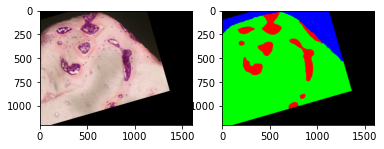

In [25]:
for src, label in zip(src_image, label_image):
    a = Augment(src, label)
    ret_img, ret_label = a.run(degree=100, center_range=0.5)
    plt.subplot(1,2,1)
    plt.imshow(ret_img[:,:,::-1])
    plt.subplot(1,2,2)
    plt.imshow(ret_label)

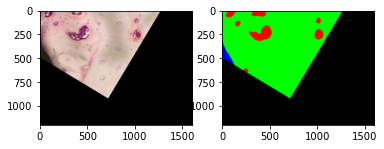

In [76]:
for src, label in zip(src_image, label_image):
    a = Augment(src, label)
    ret_img, ret_label = a.run(degree=100, center_range=0.5)
    plt.subplot(1,2,1)
    plt.imshow(ret_img[:,:,::-1])
    plt.subplot(1,2,2)
    plt.imshow(ret_label)

1. control 변수 없애기
2. output 개수 (crop하면 crop 개수 -> 이때는 crop에서 몇 번 까지 뽑아내고 새로운 변환 (인자가 2개 들어가야함, 변환 몇번, crop 몇 번), 안하면 변환 여러번)
3. reflect로 패딩 넣어주기
4. CLAHE, 밝기조절, 등등 gui로 ?